<h1 style="color:DarkTurquoise"> CrypTen Introduction / First Attempt </h1> 

This file contains code and notes for running the first implementation of CrypTen that I have tried. 


**NOTE**: once initial attempt is complete, please move this back into the crypten_case_studies folder within the driverdrowsiness application folder

In [1]:
# from models.crypten_compactcnn import CryptenCompactCNN
import torch
import crypten
import crypten.mpc as mpc 
import crypten.communicator as comm 
import numpy as np
import time
import pandas as pd
import os
from models.crypten_compactcnn import CryptenCompactCNN
from crypten.config import cfg

cfg.communicator.verbose = True

In [2]:
# define the parties involved
ALICE = 0
BOB = 1

crypten.init()
torch.set_num_threads(1)

[DEBUG]: CUDA unvailable? running on CPU


In [5]:
crypten.common.serial.register_safe_class(CryptenCompactCNN)

In [4]:
# load and encrypt network architecture
dummy_model = CryptenCompactCNN()
path = "pretrained/sub9/model.pth"

# using CryptenCompactCNN simply replaces the way in which average pooling functions
plaintext_model = CryptenCompactCNN()
plaintext_model.load_state_dict(torch.load(path, map_location="cpu"))
print(plaintext_model)
dummy_input = torch.empty((1,1,1,384))

private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)
private_model.encrypt(src=ALICE)
print("Model successfully encrypted:", private_model.encrypted)

CryptenCompactCNN(
  (conv): Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 1))
  (batch): Batchlayer()
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)
Model successfully encrypted: True


In [7]:
torch.onnx.export(plaintext_model, dummy_input, 'models/crypten-compactcnn.onnx')

/home/jjl20011/snap/snapd-desktop-integration/178/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:69: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  b = torch.div(data - mean, variance).expand(int(data.size(0)),
/home/jjl20011/snap/snapd-desktop-integration/178/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:70: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  int(data.size(1)), int(data.size(2)), int(data.size(3)))
/home/jjl20011/sna

In [3]:
# separate the labels and the data points themselves into separate ".pth" files to be compatible with CrypTen's system
from sklearn.metrics import accuracy_score

labels = torch.load("dev_work/test_features_labels/9-crypten_labels.pth")
labels.size()

torch.Size([314])

In [7]:
features = crypten.load_from_party("dev_work/test_features_labels/9-crypten_features.pth", src=ALICE)
features.size()

torch.Size([314, 1, 1, 384])

In [34]:
@mpc.run_multiprocess(world_size=2)
def sequential_eval(results_df, res_path:str='dev_work/crypten_results/'):
    '''
    iteratively perform inference (as with Delphi)
    '''
    path = "pretrained/sub9/model.pth"
    # load pre-trained model to Alice
    plaintext_model = CryptenCompactCNN()
    plaintext_model.load_state_dict(torch.load(path, map_location="cpu"))
    print(plaintext_model)
    # fitting a single input for each run of the model
    dummy_input = torch.empty((1,1,1,384))

    private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)
    private_model.encrypt(src=ALICE)

    # load data to Bob
    features = crypten.load_from_party("dev_work/test_features_labels/9-crypten_features.pth", src=BOB)
    # is this step necessary? try it out once the multiprocess thing works properly
    pred_array = np.zeros(len(features))
    current = 0
    for i in range(len(features)): 
        current += 1
        if current > 15:
            print("Progress = {}".format(i/len(features)))
            current = 0

        # print(features[i].reshape((1,1,1,384)).size())
        start = time.time()
        output_enc = private_model(features[i])
        pred = output_enc.get_plain_text()
        pred = pred.argmax(axis=-1)
        end = time.time()
        
        # print(pred)
        if labels[i] == pred[0]: pred_array[i] = 1
        else: pred_array[i] = 0

        # save individual timing information
        new_row = {'feature input': 'input {}'.format(i), 
                   'running time': end - start, 
                   'result': pred_array[i]}
        
        # save result by adding new row to dataframe
        results_df = pd.concat([results_df, pd.DataFrame([new_row])], 
                               ignore_index=True)
        
        # print(pred)
        if labels[i] == pred[0]: pred_array[i] = 1
        else: pred_array[i] = 0
        
    acc = np.sum(pred_array)/len(features)
    results_df.to_csv('{}seq_results_{}.csv'.format(res_path, os.getpid()), 
                      index=False)
    

In [19]:
os.getpid()

3687069

create dataframe to hold results data

In [35]:
c1 = pd.Series(data=None, dtype='string', name='feature input')
c2 = pd.Series(data=None, dtype='float', name='running time')
c3 = pd.Series(data=None, dtype='int', name='result')

dat = pd.concat([c1, c2, c3], axis=1)

run the sequential eval and save the results

In [36]:
dat = sequential_eval(dat)

CryptenCompactCNN(
  (conv): Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 1))
  (batch): Batchlayer()
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)CryptenCompactCNN(
  (conv): Conv2d(1, 32, kernel_size=(1, 64), stride=(1, 1))
  (batch): Batchlayer()
  (fc): Linear(in_features=32, out_features=2, bias=True)
  (softmax): LogSoftmax(dim=1)
)



/home/jjl20011/snap/snapd-desktop-integration/83/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:69: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/jjl20011/snap/snapd-desktop-integration/83/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:69: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
/home/jjl20011/snap/snapd-desktop-integration/83/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten

Progress = 0.04777070063694268Progress = 0.04777070063694268

Progress = 0.09872611464968153Progress = 0.09872611464968153

Progress = 0.14968152866242038Progress = 0.14968152866242038

Progress = 0.20063694267515925Progress = 0.20063694267515925

Progress = 0.2515923566878981Progress = 0.2515923566878981

Progress = 0.30254777070063693Progress = 0.30254777070063693

Progress = 0.3535031847133758Progress = 0.3535031847133758

Progress = 0.40445859872611467Progress = 0.40445859872611467

Progress = 0.4554140127388535Progress = 0.4554140127388535

Progress = 0.5063694267515924Progress = 0.5063694267515924

Progress = 0.5573248407643312Progress = 0.5573248407643312

Progress = 0.60828025477707Progress = 0.60828025477707

Progress = 0.6592356687898089Progress = 0.6592356687898089

Progress = 0.7101910828025477Progress = 0.7101910828025477

Progress = 0.7611464968152867Progress = 0.7611464968152867

Progress = 0.8121019108280255Progress = 0.8121019108280255

Progress = 0.8630573248407644Pro

Import the results and review them using plotnine

In [2]:
results = pd.read_csv("dev_work/crypten_results/seq_results_3697259.csv")

In [3]:
results.head()

,feature input,running time,result
0,input 0,0.628804,0.0
1,input 1,0.582685,1.0
2,input 2,0.581894,1.0
3,input 3,0.587549,0.0
4,input 4,0.540805,0.0


<Axes: >

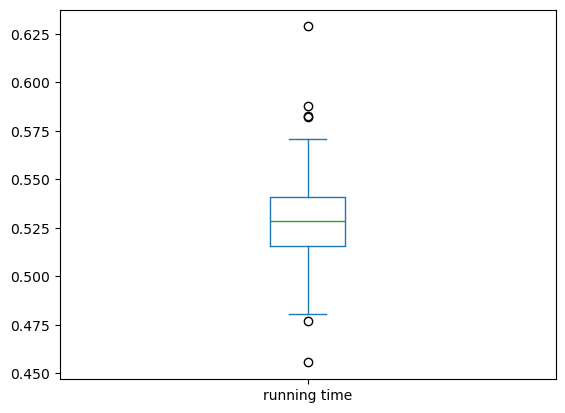

In [4]:
results['running time'].plot(kind='box')

In [6]:
throughput = results.shape[0]/results['running time'].sum()

In [7]:
throughput

1.8921041192134758

In [15]:
results['inference num'] = results.index
results['result plot'] = results['result'].astype('object')
results['running time plot label'] = 'running time'
results.loc[results['result'] == 1, ['result label', 'color']]= ['correct', '#00BA42'] 
results.loc[results['result'] == 0, ['result label', 'color']] = ['incorrect', 'red']

In [16]:
results.describe()

,running time,result,inference num
count,314.000000,314.000000,314.000000
mean,0.528512,0.818471,156.500000
std,0.019463,0.386071,90.788215
min,0.455521,0.000000,0.000000
25%,0.515796,1.000000,78.250000
50%,0.528463,1.000000,156.500000
75%,0.541109,1.000000,234.750000
max,0.628804,1.000000,313.000000


In [17]:
1/results['running time'].mean()

1.8921041192134758

In [10]:
from plotnine import *

/home/jjl20011/miniconda3/envs/crypten_env/lib/python3.9/site-packages/plotnine/guides/guides.py:197: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


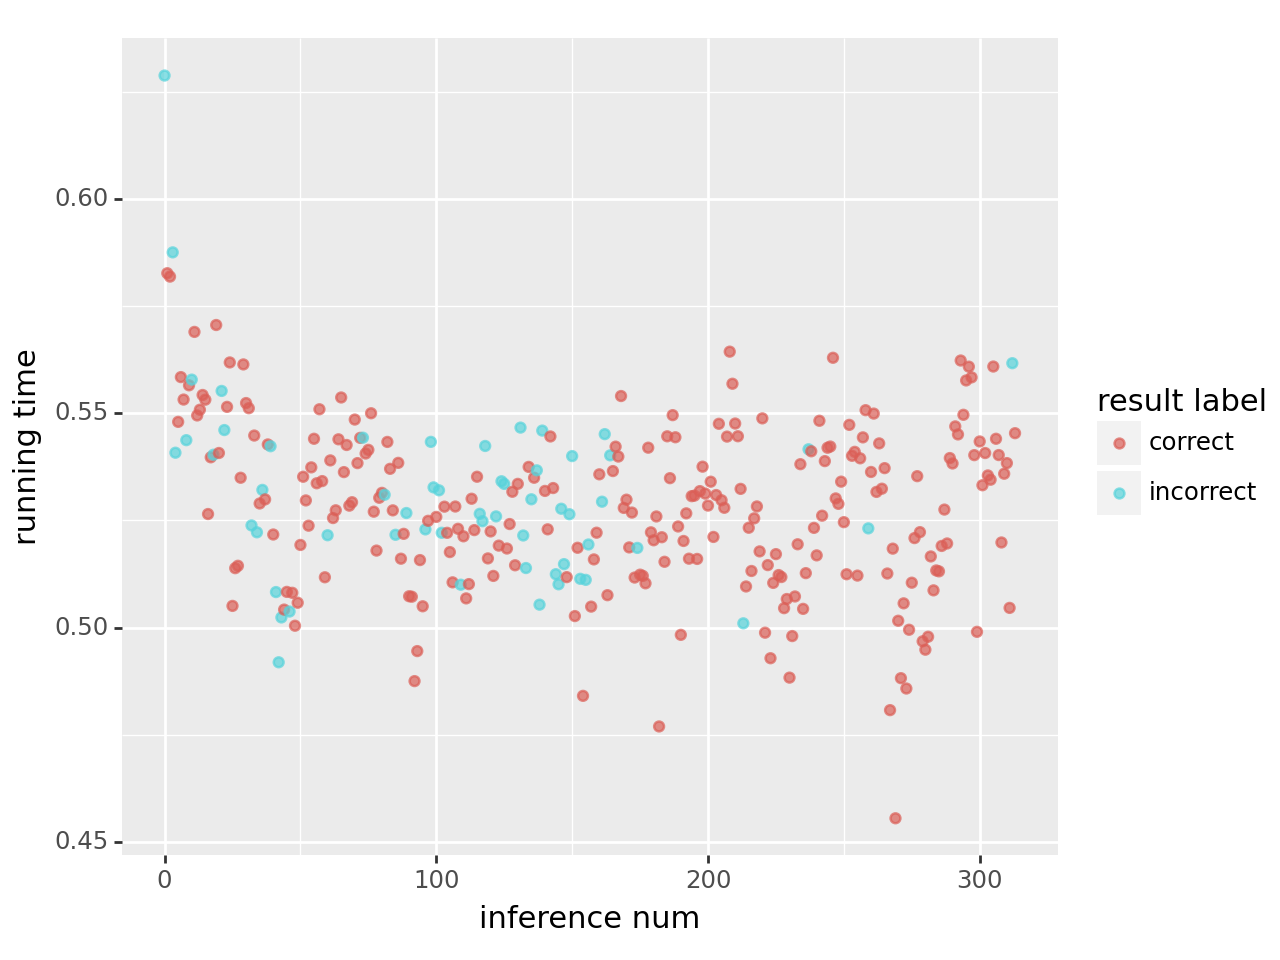

<Figure Size: (640 x 480)>

In [13]:
fill_colors = ['red', '#00BA42']

(ggplot(results, aes(x='inference num', y='running time', color='result label'))
    + geom_point(alpha=0.7)
    + scale_fill_manual(values=fill_colors))

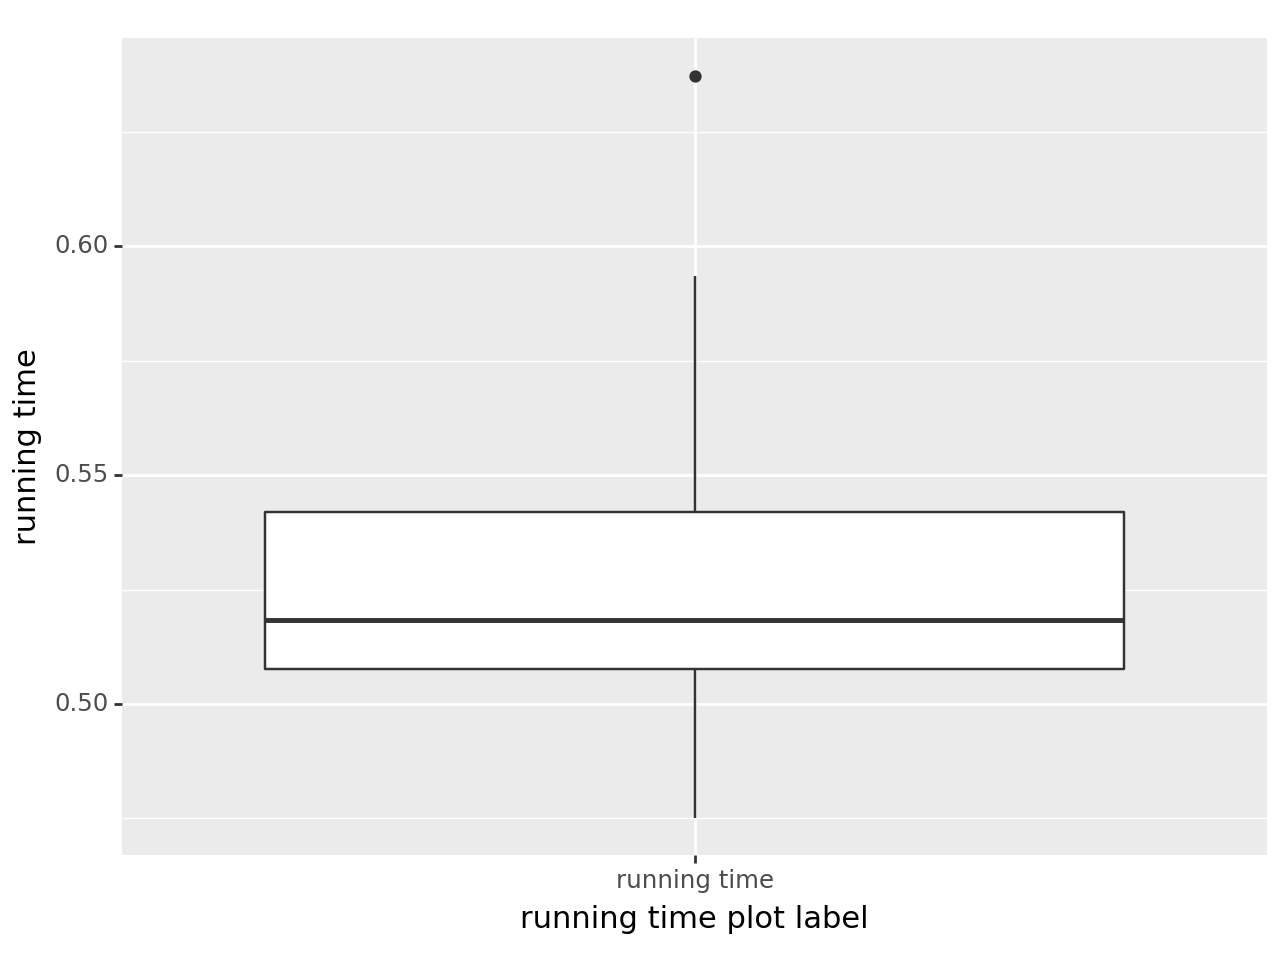

<Figure Size: (640 x 480)>

In [28]:
(ggplot(results, aes(x='running time plot label', y='running time'))
    + geom_boxplot())

In [7]:
(4*60 + 26.1)/314

0.8474522292993631

In [5]:
def compute_accuracy(output, labels):
    # need to convert this to cpu or numpy? experiment once multiprocess decorator begins to work properly
    pred = output.argmax(axis=-1)
    correct = pred.eq(labels)
    correct_count = correct.sum(0, keepdim=True).float()
    accuracy = correct_count.mul_(100.0 / output.size(0))
    return accuracy

@mpc.run_multiprocess(world_size=2)
def evaluate_model():
    rank = comm.get().get_rank()
    path = "pretrained/sub9/model.pth"
    # load pre-trained model to Alice
    plaintext_model = CryptenCompactCNN()
    plaintext_model.load_state_dict(torch.load(path, map_location="cpu"))
    
    dummy_input = torch.empty((1,1,1,384))

    private_model = crypten.nn.from_pytorch(plaintext_model, dummy_input)
    private_model.encrypt(src=ALICE)
    
    # load data to Bob
    features = crypten.load_from_party("dev_work/test_features_labels/9-crypten_features.pth", src=BOB)[0] # only one feature
    # is this step necessary? try it out once the multiprocess thing works properly
    # flattened_features = features.flatten(start_dim=1)
    
    if rank == ALICE: 
        print("[INFO]: Alice share of Bob's features = {}".format(features))
    if rank == BOB: 
        print("[INFO]: Bob's share of Bob's features = {}".format(features))

    # classify the encrypted data
    private_model.eval()

    start = time.time()
    output_enc = private_model('cpu', features)
    end = time.time()

    # inference time: 
    print("inference time: {}".format(end - start))

    # compute the accuracy
    output = output_enc.get_plain_text()
    crypten.print(output.size())
    # accuracy = compute_accuracy(output, labels)
    # crypten.print("\tAccuracy: {0:.4f}".format(accuracy.item()))
    
    com_stats = comm.get().get_communication_stats()
    print("[INFO]: communication cost = {}".format(com_stats))

evaluate_model()

[DEBUG]: CUDA unvailable? running on CPU


/home/jjl20011/snap/snapd-desktop-integration/247/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:69: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  b = torch.div(data - mean, variance).expand(int(data.size(0)),
/home/jjl20011/snap/snapd-desktop-integration/247/Lab/Projects/Project1-V2X-Secure2PC/v2x-delphi-2pc/case_studies/driverdrowsiness/models/crypten_compactcnn.py:69: TracerWarning: Converting a tensor to a Python integer might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  b = torch.div(data - mean, variance).expand(int(data.size(0)),
/home/jjl200

[INFO]: Bob's share of Bob's features = MPCTensor(
	_tensor=tensor([[[ -320493035680578733,  4353776266898020128, -7351636370822289605,
           6110491296284754190, -9007546597534805107,  1896125065832318395,
           2347309774049907930,   199335838061850671, -3997929240061298819,
           6422426727646040700, -6008723898315819757, -1814973123750934591,
           8401044263690684108,  6718872848428082877, -4407735765946892852,
            469378408644181778,  8259046894958088865,  6048856464598513404,
           2477922124820961975,  3626793486087841312,  3887523772716670508,
           8001082212657508797,  2696448302145944804,  4222283483476037103,
           1610424192699286969,  7301997914789965772,  -803513798300862790,
           7917779511377032550,  -565518931491827613,  7889169068075315595,
          -4309224547640603125, -5091198803434909155,  8965094431995164183,
          -7259417495975525225,  2567191403779047367,  2166545606158478972,
          -77986113521753024

KeyboardInterrupt: 

inference time: 308.1009042263031inference time: 308.10113191604614

torch.Size([314, 2])[INFO]: communication cost = {'rounds': 132, 'bytes': 49600836328.0, 'time': 25.32212919794256}

[INFO]: communication cost = {'rounds': 132, 'bytes': 49600836264.0, 'time': 21.164415931038093}


**Trouble Shooting**

One main issue with CrypTen arose while working with the tutorials `@mpc.run_multiprocess(world_size=x)` was `RuntimeError: CUDA Initialization Error`. This can be resolved (I think) by using the following series of commands: 

```bash
conda env config vars set CONDA_VISIBLE_DEVICES=""
conda deactivate
conda activate crypten_env
```

These commands simply set the conda environment variable, deactivate and then reactivate the conda environment - this is necessary to make sure that the environment variables are set properly

<h3 style="color:LightSalmon"> 